In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)



In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
left = left.sort_values(by='node')
# インデックスを振り直す
left = left.reset_index(drop=True)
left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [6]:
# 正規化する
left["node_norm"] = left["node"] - left["node"].min() + 2
left["edge_norm"] = left["edge"] - left["edge"].min() + 1

# インデックスを振り直す
left = left.reset_index(drop=True)



In [7]:
def model_uniform_2(x, M):
    kappa = (8 * M) / (x[0] * (x[0] - 1))
    res = x[0] * (1 - (2 / (kappa * x[0])) * (1 - ((1 - (kappa / 2))**x[0])))  
    return res

In [8]:
x = left["edge_norm"]
y = left["node_norm"]

In [9]:
# xとyの最初の値を削除
x = x[1:]
y = y[1:]

# インデックスを振り直す
x = x.reset_index(drop=True)
y = y.reset_index(drop=True)

In [10]:
# 残差
def residual_uniform_2(x, N, M):
    return N - model_uniform_2(x, M)

In [11]:
# 目的関数
def f_uniform_2(x, N, M):
    return np.sum(residual_uniform_2(x, M, N)**2)

In [29]:
# curve_fitでパラメータを推定
params = optimize.curve_fit(model_uniform_2, x, y)
print(params[0])


[554.31990559]


In [32]:
# 元の関数に代入する
Np_norm_hat = 554.31
print("+------------------+")
kappa_norm_estimated = [((8 * x[i]) / (Np_norm_hat * (Np_norm_hat - 1))) for i in range(len(x))]

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * (1 - (2 / (kappa_norm_estimated[i]*Np_norm_hat)) * (1 - (1 - (kappa_norm_estimated[i] / 2))**Np_norm_hat)) )
    M_norm.append( (kappa_norm_estimated[i] * Np_norm_hat * (Np_norm_hat - 1)) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", left["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")

+------------------+
|      DONE        |
+------------------+
| Np:  554.31
| N max:  514
| kappa:  0.000834677549737709
| N:  59.352996278564596
| M:  32.0
+------------------+


+------------------+
|      DONE        |
+------------------+
| Np:  554.31
| N max:  514
| kappa:  0.000834677549737709
| N:  59.352996278564596
| M:  32.0
+------------------+


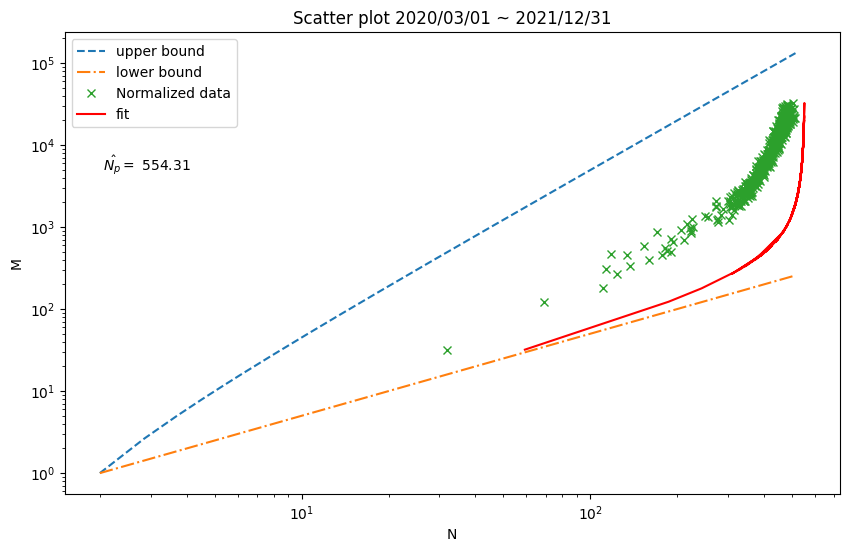

In [34]:
# 可視化
nn = len(left) - 1
xmin = min(left["node_norm"])
xmax = max(left["node_norm"])
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

Np_norm_hat = 554.31
print("+------------------+")
kappa_norm_estimated = [((8 * x[i]) / (Np_norm_hat * (Np_norm_hat - 1))) for i in range(len(x))]

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * (1 - (2 / (kappa_norm_estimated[i]*Np_norm_hat)) * (1 - (1 - (kappa_norm_estimated[i] / 2))**Np_norm_hat)) )
    M_norm.append( (kappa_norm_estimated[i] * Np_norm_hat * (Np_norm_hat - 1)) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", left["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")



plt.figure(figsize=(10, 6))
plt.title("Scatter plot 2020/03/01 ~ 2021/12/31")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.plot(y, x, "x", label='Normalized data')
plt.plot(N_norm, M_norm, label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

+------------------+
|      DONE        |
+------------------+
| Np:  431.626033782959
| N max:  514
| kappa:  4.3040972308942156e-05
| N:  1.9938503478010876
| M:  1.0
+------------------+


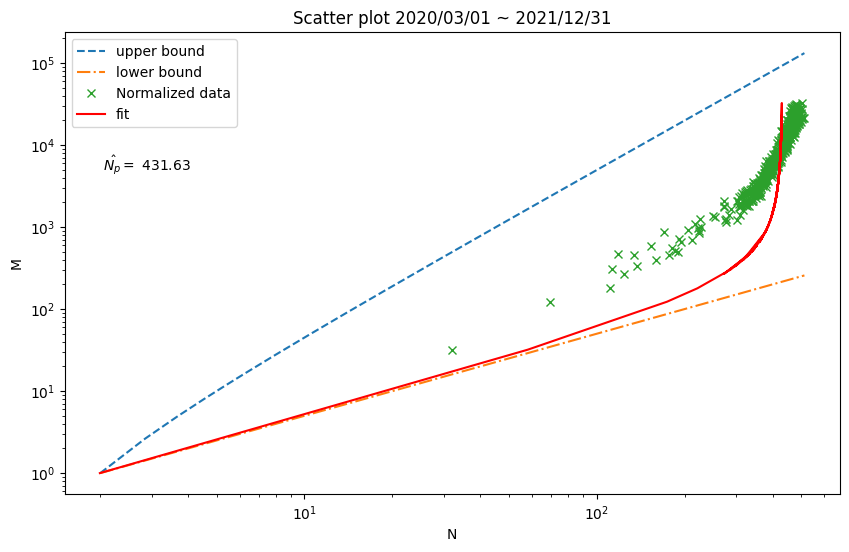

In [22]:
# 可視化
nn = len(left["node_norm"]) - 1
xmin = min(left["node_norm"])
xmax = max(left["node_norm"])
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

# 元の関数に代入する
Np_norm_hat = res.x[0]
print("+------------------+")
kappa_norm_estimated = [((8 * left["edge_norm"][i]) / (Np_norm_hat * (Np_norm_hat - 1))) for i in range(len(left["edge_norm"]))]

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * (1 - (2 / (kappa_norm_estimated[i]*Np_norm_hat)) * (1 - (1 - (kappa_norm_estimated[i] / 2))**Np_norm_hat)) )
    M_norm.append( (kappa_norm_estimated[i] * Np_norm_hat * (Np_norm_hat - 1)) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", left["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")


plt.figure(figsize=(10, 6))
plt.title("Scatter plot 2020/03/01 ~ 2021/12/31")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.plot(y, x, "x", label='Normalized data')
plt.plot(N_norm, M_norm, label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [26]:
print(max(left["node_norm"]))

514
